## 0. Preparations

In [1]:
# Check for libraries being up-to-date
# This notebook was created and tested under python 3.12
! pip install -q -U pandas numpy matplotlib xgboost shap numba statsmodels seaborn geopandas geodatasets

In [2]:
# Import the libraries as needed
import pandas as pd
import geopandas as gpd
import geodatasets as gds
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import shap
import seaborn as sb

%matplotlib inline

/home/arno/.local/share/hatch/env/virtual/p2/ayWFfer_/p2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_rel
from statsmodels.tsa.stattools import grangercausalitytests

In [4]:
INTERPOLATE=False

In [5]:
PLOT_COLOR="royalblue"

In [6]:
def get_series_col(df):
    # Little tool to find column name
    series_col="Series Name"
    if not series_col in df.columns:
        series_col="Series"
        if not series_col in df.columns:
            print ("Please add Series column name here!")
            print (df.series_col) # This is meant to fail ungracefully. Fix is needed in that case
    return series_col

In [7]:
def clean_worldbank_df(df):
    # clean data from world bank
    df=df[df["Country Code"].str.len()==3]
    df=df.replace("..",np.nan).infer_objects(copy=False) # to remedy the warning about deprecated downcasting
    df[df.columns[4:]]=df[df.columns[4:]].astype(float)
    return df

In [8]:
def extract_features_for_year(df,year,interpolate_features=None,drop_na=True,select_features=None):
    # Selecting features for a given year. select_features should be given as dict which translates column names
    # This adjusts and simplifies the structure of our data from how it is found in the downloads
    series_col=get_series_col(df)
    if INTERPOLATE: # we tried this, but prefer to skip this, and thus we set INTERPOLATE to False above
        df.loc[:,df.columns[4:]]=df.loc[:,df.columns[4:]].interpolate(method='linear', axis=0)
    elif interpolate_features: # this is also skipped as we decided against interpolation
        row_select=df[series_col].isin(interpolate_features)
        df.loc[row_select,df.columns[4:]]=df.loc[row_select,df.columns[4:]].interpolate(method='linear', limit_area="inside",axis=0)
    SELECT_YEAR_STR=f"{year} [YR{year}]"
    
    # We start in selecting a year later than we chose above, and the countries which remained in the education data for having all features we want
    features=df[series_col].unique()
    if not select_features:
        select_features={feature:feature for feature in features}
    result_features=select_features.values()
    features=select_features.keys()

    # Separate Series for each feature in a dict
    dfs={
        select_features[feature]:
        df[df[series_col]==feature].set_index("Country Code")[SELECT_YEAR_STR]
        for feature in select_features.keys()
    }

    # Final DataFrame for the targets
    result_df=pd.DataFrame()
    print ("We use the following features:\n")
    for feature in dfs.keys():
        print (feature)
        result_df[feature]=dfs[feature]
    
    # drop countries with missing data
    if drop_na:
        drop_countries=result_df[result_df.isna().sum(axis=1)>0].index.values
        result_df.drop(drop_countries,inplace=True)
    print (f"\nWe found complete data for {result_df.shape[0]} countries.") 
    return result_df,result_df.columns

In [9]:
def eval_rmse(model,X,y):
    # returns rmse of a model's prediction of X, compared to y
    return mean_squared_error(y,model.predict(X))**0.5

In [10]:
def show_feature_hist(df,xlim=None):
    # plots the distribution of how many values we have per year
    series_col=get_series_col
    features=df[series_col].unique()
    dfs={
        feature:
        df[df[series_col]==feature].set_index("Country Code")
        for feature in features
    }

    # show plots for each feature, show how many contries did report figure in each year
    fig,axs=plt.subplots(nrows=len(features),figsize=(40,6*len(features)))
    for n,feature in enumerate(features):
        dfx=dfs[feature]
        length=dfx.shape[0]
        feature_count=length-dfx.isna().sum()
        axs[n].bar(height=feature_count[3:],x=dfx.columns[3:],color=PLOT_COLOR)
        axs[n].set_xlabel(f"{n}: {feature}")
        axs[n].set_xticks(range(len(dfx.columns)-3))
        axs[n].set_xticklabels([x[:4] for x in dfx.columns[3:]],rotation=90)
        # adjust to useful data range 1968 - 2025
        if xlim:
            axs[n].set_xlim(xlim[0],xlim[1])
    plt.show()

## 1. Education expenditure data

In [11]:
# Load data from the Education data file. This is about selecting our features

EDU_FILE="WB/Education/Education_Data.csv"
edu=pd.read_csv(EDU_FILE)
edu=clean_worldbank_df(edu)

/tmp/ipykernel_1700460/1916138962.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df=df.replace("..",np.nan).infer_objects(copy=False) # to remedy the warning about deprecated downcasting


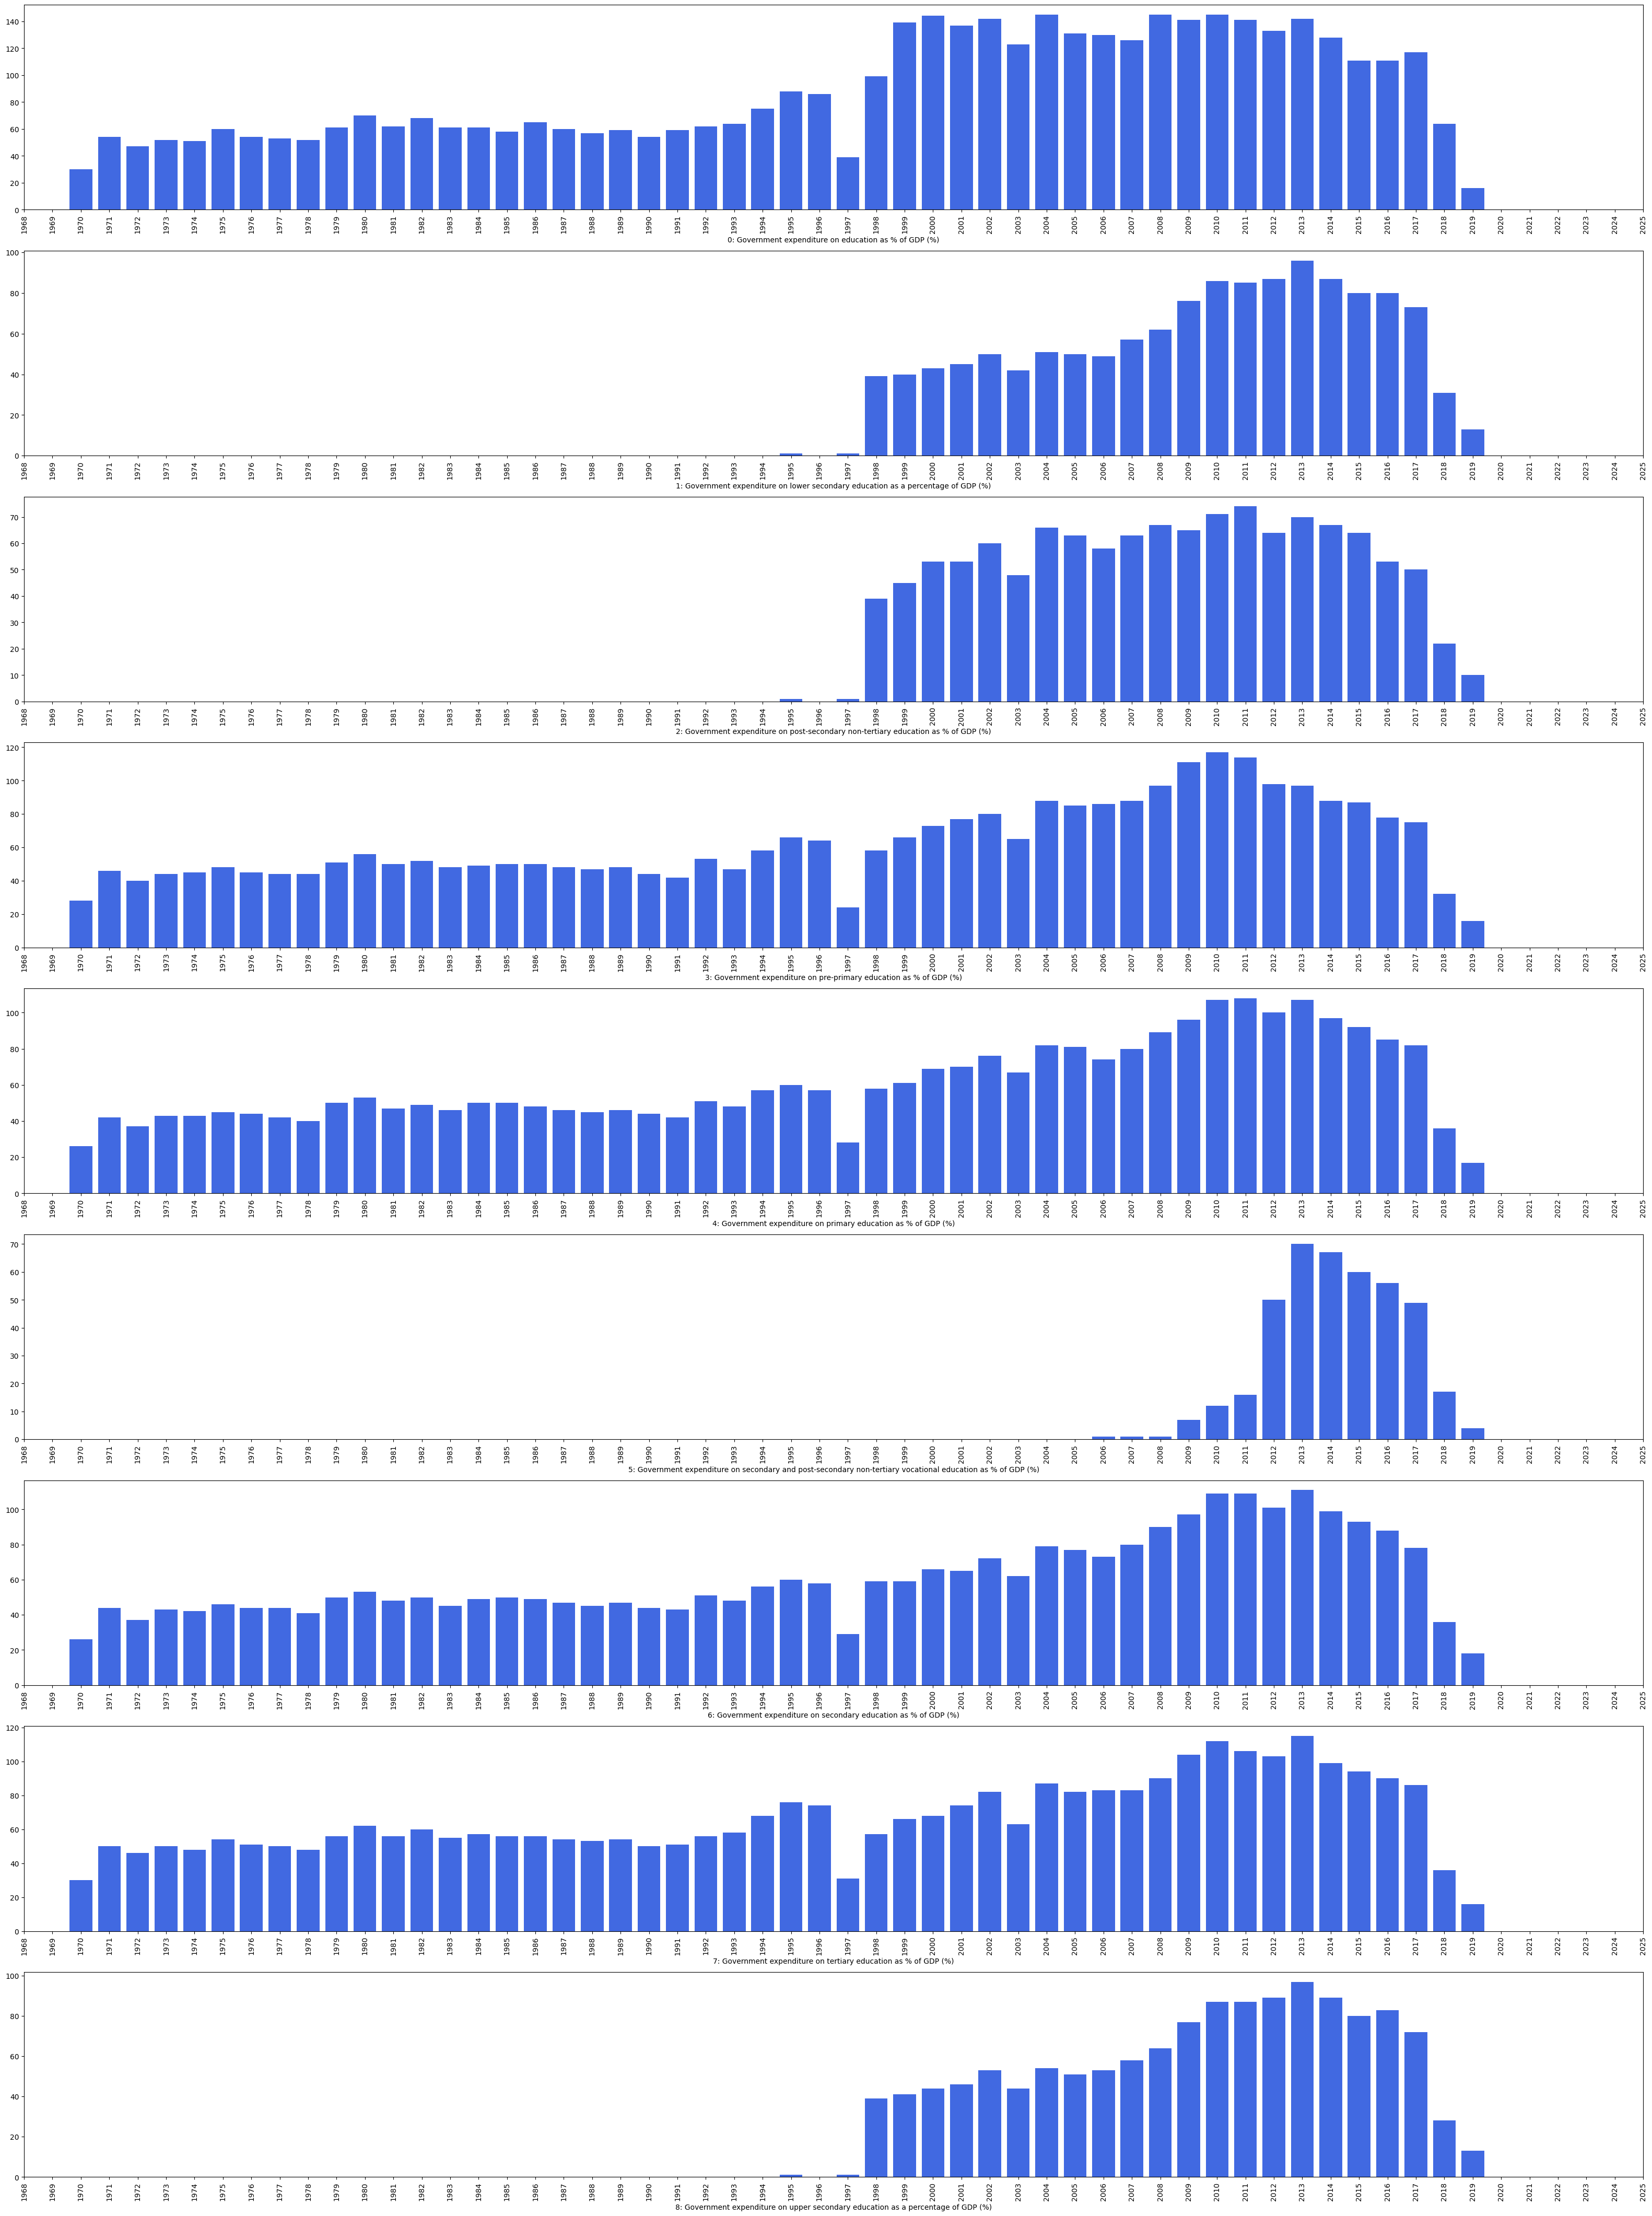

In [12]:
# create plots to show how much data we have in each feature over the years
show_feature_hist(edu,(8,65))

In [13]:
edu_feature_dict={
    'Government expenditure on education as % of GDP (%)':"Total_expenditure_GDP_pct",
    'Government expenditure on primary education as % of GDP (%)':"Primary_expenditure_GDP_pct",
    'Government expenditure on secondary education as % of GDP (%)':"Secondary_expenditure_GDP_pct",
    'Government expenditure on tertiary education as % of GDP (%)':"Tertiary_expenditure_GDP_pct"
}
edu_df,edu_features=extract_features_for_year(edu,2010,select_features=edu_feature_dict)



We use the following features:

Total_expenditure_GDP_pct
Primary_expenditure_GDP_pct
Secondary_expenditure_GDP_pct
Tertiary_expenditure_GDP_pct

We found complete data for 96 countries.



## 2. World Development Index data


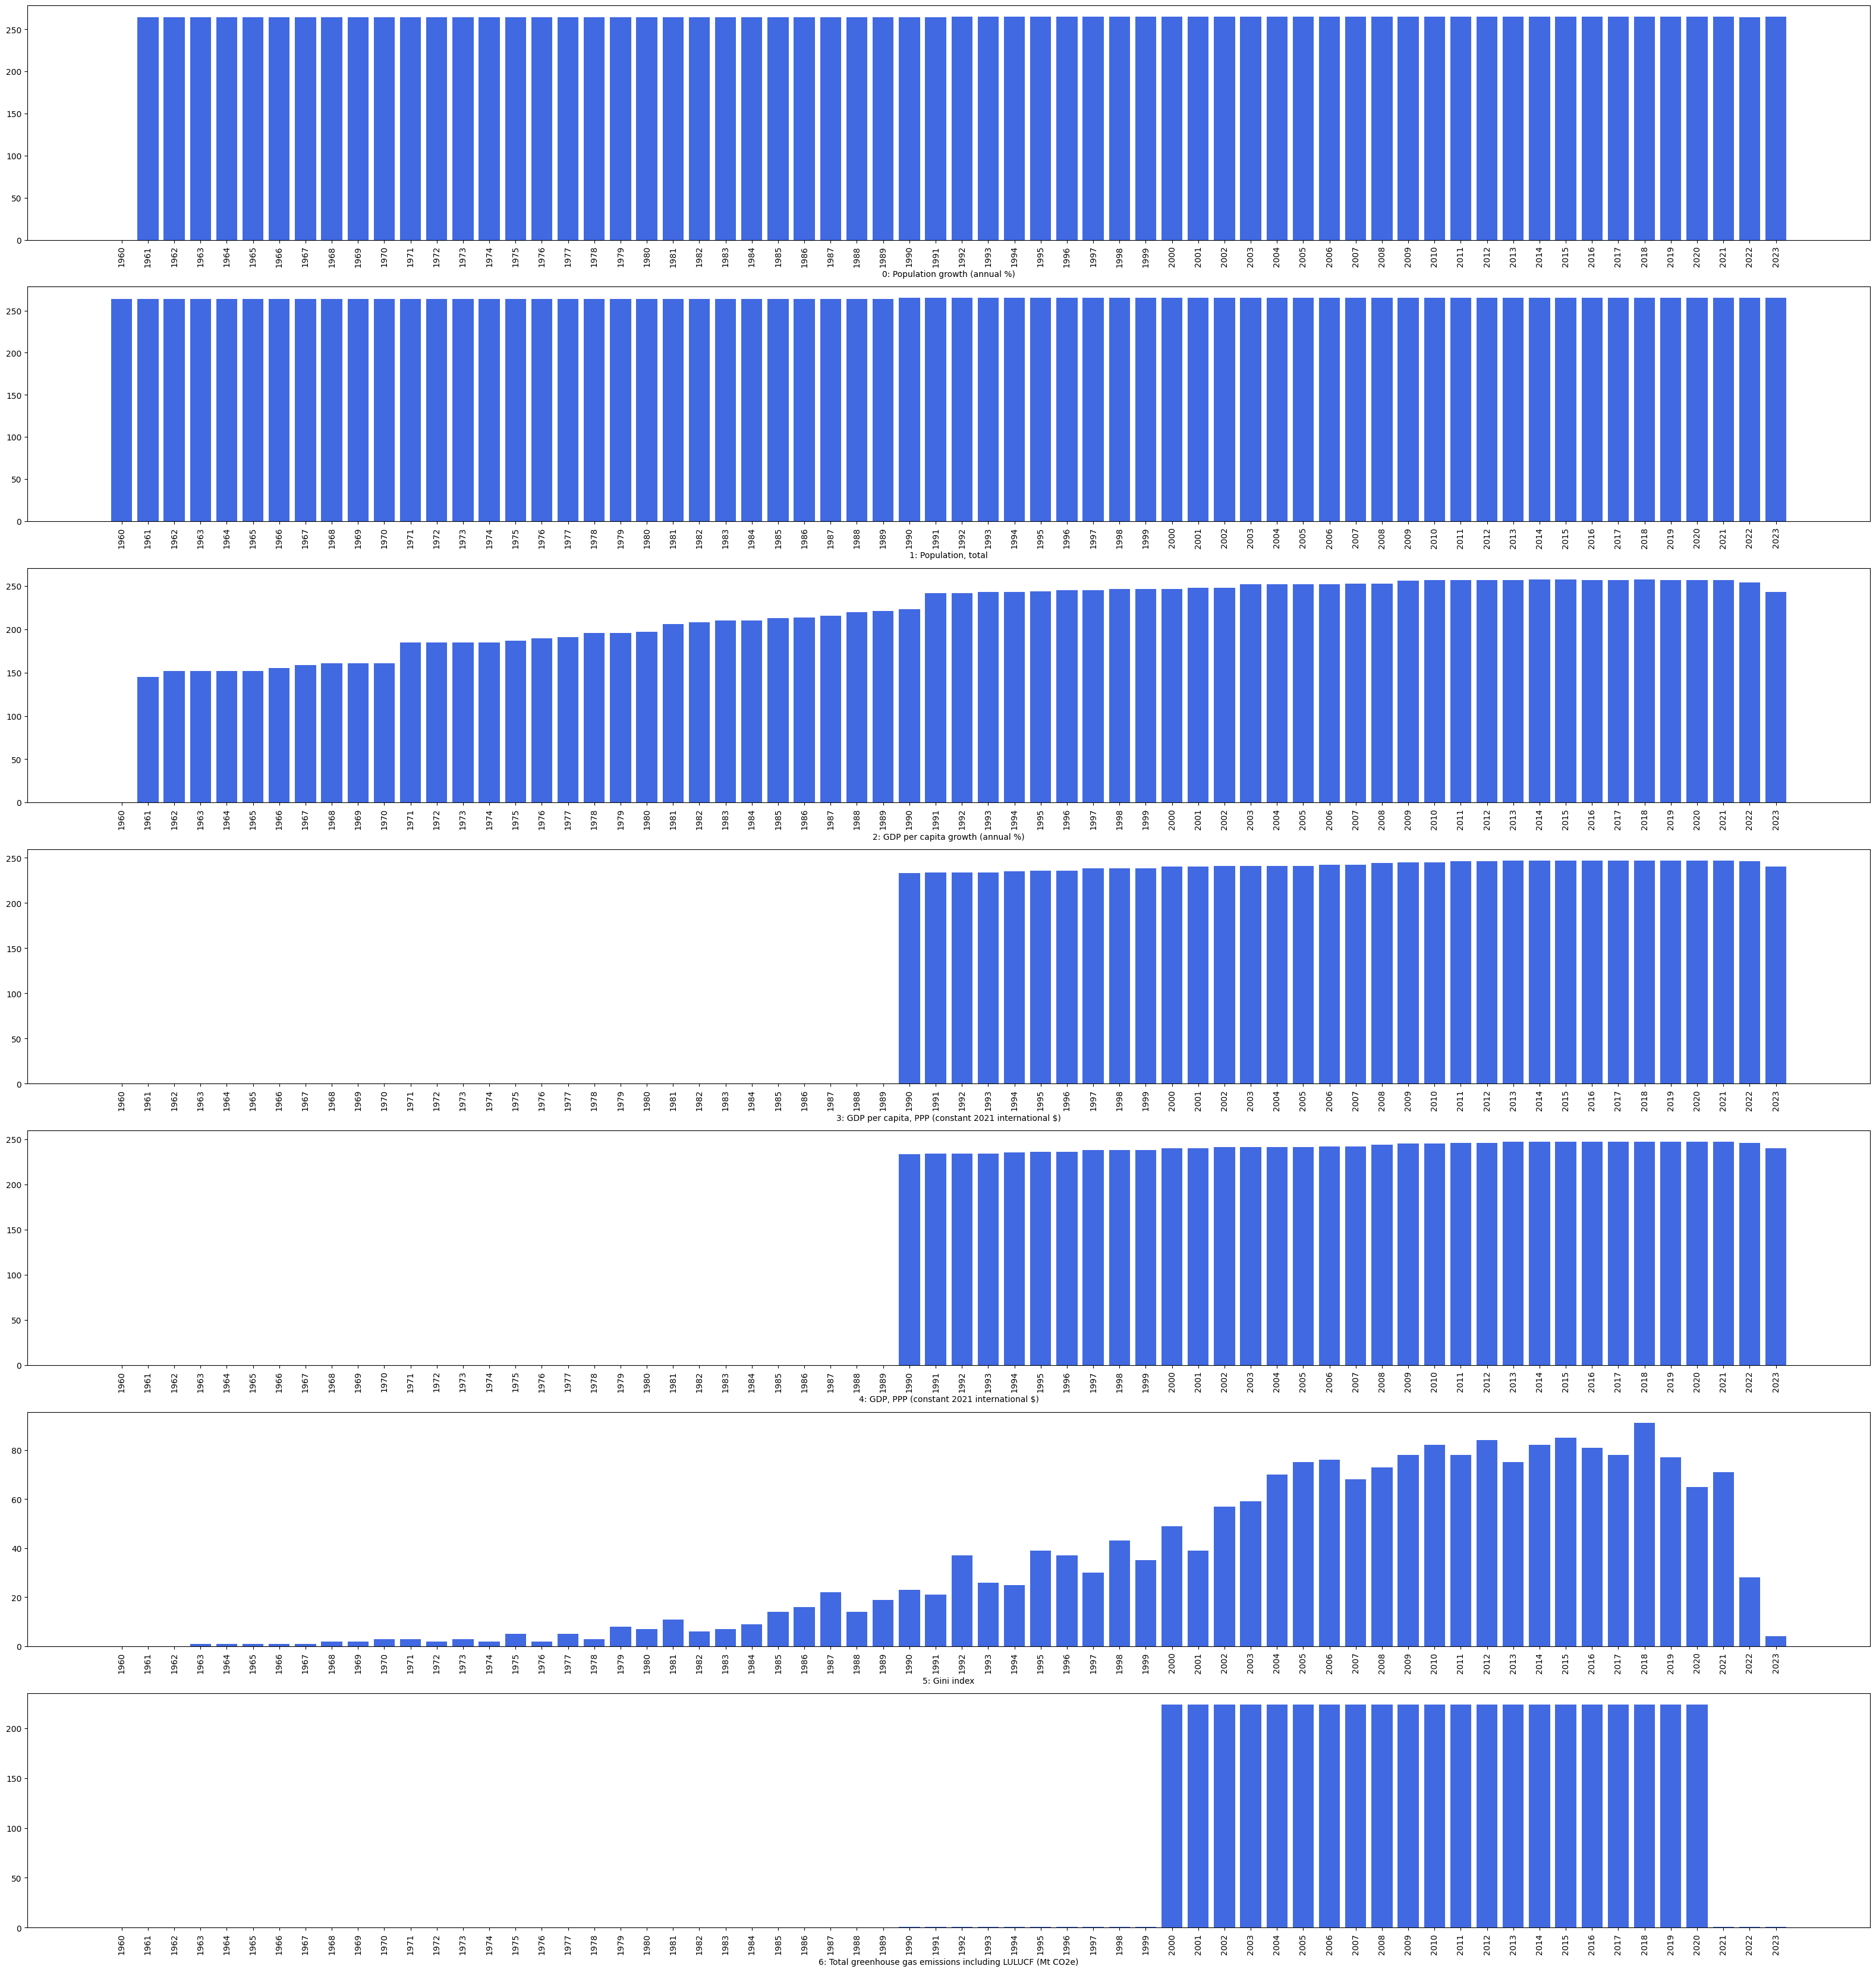

In [14]:
# Load data from World development index
WDI_FILE="WB/WDI/WDI_Data.csv"
wdi=pd.read_csv(WDI_FILE)
wdi=clean_worldbank_df(wdi)
show_feature_hist(wdi)

In [15]:
WDI_SELECT_YEAR=2018
wdi_df,wdi_features=extract_features_for_year(wdi,WDI_SELECT_YEAR,
    interpolate_features=["Gini index"]
    )

wdi_df["Total greenhouse incl. LULUCF t CO2e per capita"]=wdi_df["Total greenhouse gas emissions including LULUCF (Mt CO2e)"]*1e6/wdi_df["Population, total"].astype(float)
wdi_df["GDP, PPP (constant 2021 international $)"]=wdi_df["GDP, PPP (constant 2021 international $)"]/1e9 # Billions
wdi_df["Population, total"]=wdi_df["Population, total"]/1e6 # Millions
wdi_df

We use the following features:

Population growth (annual %)
Population, total
GDP per capita growth (annual %)
GDP per capita, PPP (constant 2021 international $)
GDP, PPP (constant 2021 international $)
Gini index
Total greenhouse gas emissions including LULUCF (Mt CO2e)

We found complete data for 168 countries.


,Population growth (annual %),"Population, total",GDP per capita growth (annual %),"GDP per capita, PPP (constant 2021 international $)","GDP, PPP (constant 2021 international $)",Gini index,Total greenhouse gas emissions including LULUCF (Mt CO2e),Total greenhouse incl. LULUCF t CO2e per capita
Country Code,,,,,,,,
ALB,-0.246732,2.866376,4.276312,14698.537618,42.131535,30.1,10.4528,3.646695
DZA,1.937806,42.505035,-0.546020,15343.426122,652.172864,35.4,239.7553,5.640633
AGO,3.453233,31.297155,-4.665970,8620.214664,269.788194,51.3,139.9142,4.470509
ATG,0.504979,0.090926,6.414456,28884.120130,2.626318,46.5,0.3239,3.562237
ARG,0.822969,44.654882,-3.415537,27367.115094,1222.075295,41.7,403.1020,9.027053
...,...,...,...,...,...,...,...,...
USA,0.526435,326.838199,2.425877,68070.213422,22247.945960,41.4,5528.3734,16.914710
URY,0.179744,3.394534,-0.015101,29854.618893,101.342519,39.7,27.0887,7.980094
UZB,1.727069,32.373490,3.751768,8348.960579,270.284992,38.7,187.4227,5.789388


## 3. Economic Fitness Data

In [16]:
EFIT_FILE="WB/Eco_Fitness/Eco_Fitness_Data.csv"
efit=pd.read_csv(EFIT_FILE)
efit=clean_worldbank_df(efit)

efit_df,efit_features=extract_features_for_year(efit,WDI_SELECT_YEAR)

We use the following features:

Economic Fitness Metric
Universal Economic Fitness Metric

We found complete data for 171 countries.


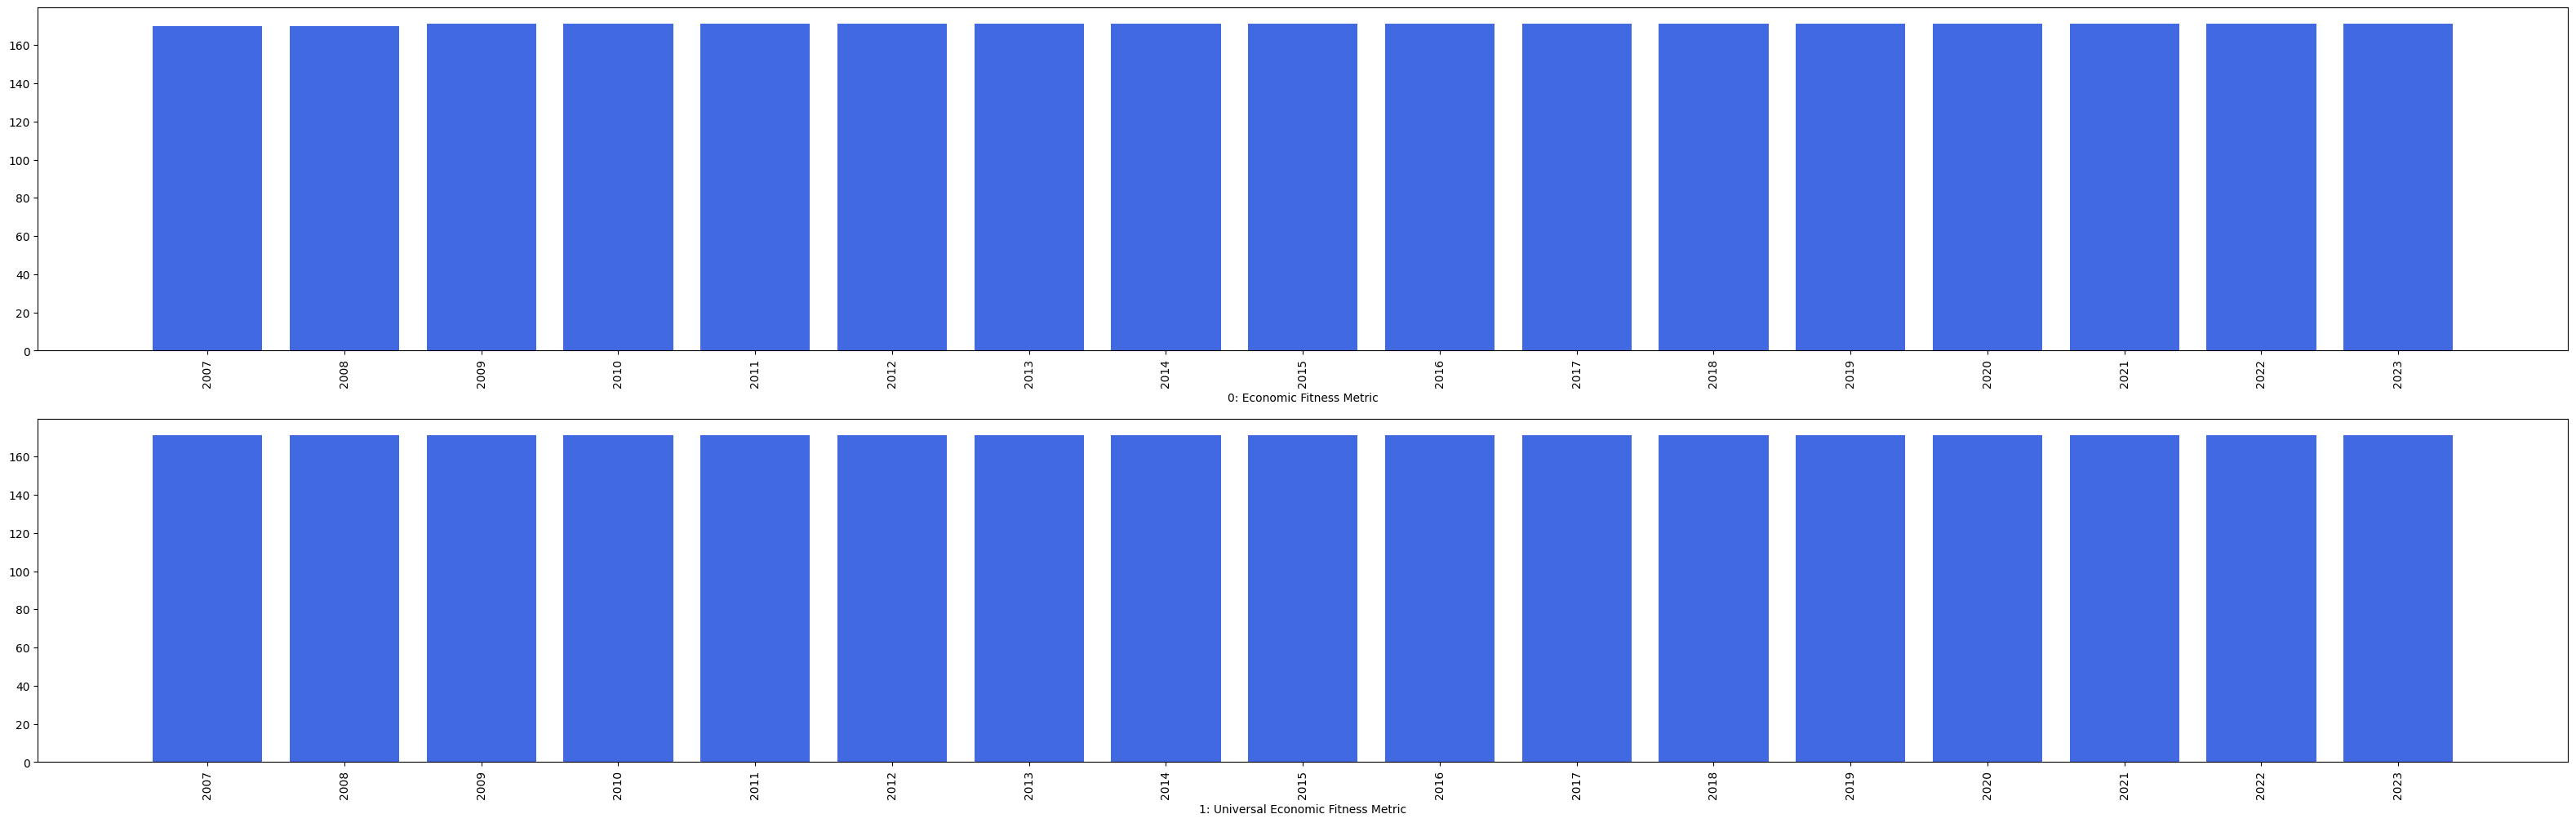

In [17]:
show_feature_hist(efit)

In [18]:
# make one nice dataframe of all the data found
df=pd.DataFrame()
df[edu_df.columns]=edu_df
df[wdi_df.columns]=wdi_df
df[efit_df.columns]=efit_df
df=df[df.isna().sum(axis=1)==0]
features=df.columns[:4]
targets=list(df.columns[[7,9,12]])

In [19]:
df.describe()

,Total_expenditure_GDP_pct,Primary_expenditure_GDP_pct,Secondary_expenditure_GDP_pct,Tertiary_expenditure_GDP_pct,Population growth (annual %),"Population, total",GDP per capita growth (annual %),"GDP per capita, PPP (constant 2021 international $)","GDP, PPP (constant 2021 international $)",Gini index,Total greenhouse gas emissions including LULUCF (Mt CO2e),Total greenhouse incl. LULUCF t CO2e per capita,Economic Fitness Metric,Universal Economic Fitness Metric
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,4.481171,1.473673,1.609555,0.939895,1.343668,44.171101,2.314017,26142.907286,733.796412,35.794789,194.650226,4.442336,1.150645,0.926764
std,1.635767,0.633503,0.730868,0.504281,1.188165,153.488903,2.547491,25318.385332,1556.804651,6.108897,479.122944,12.629370,0.972812,2.001682
min,1.117610,0.430240,0.268170,0.089680,-1.757004,0.352721,-4.658140,868.555508,4.367581,24.600000,-216.693500,-44.416629,0.037360,0.000642
25%,3.465958,0.971873,0.996660,0.559185,0.419133,4.875822,1.048748,6188.531782,38.519302,31.882143,10.387975,1.673885,0.382770,0.017956
50%,4.530445,1.401845,1.678840,0.934765,1.259465,11.244687,2.111449,15309.619603,121.547412,35.150000,48.918200,4.967326,0.792766,0.113765
75%,5.546610,1.813380,2.110017,1.238938,2.426917,30.952585,3.926073,41764.050384,628.133673,38.650000,92.561125,8.683764,1.727737,1.122369
max,8.559550,3.340950,3.317650,2.339230,3.491955,1374.659064,7.431770,119343.145528,10604.587056,53.900000,3354.046800,66.031841,4.270849,13.631335


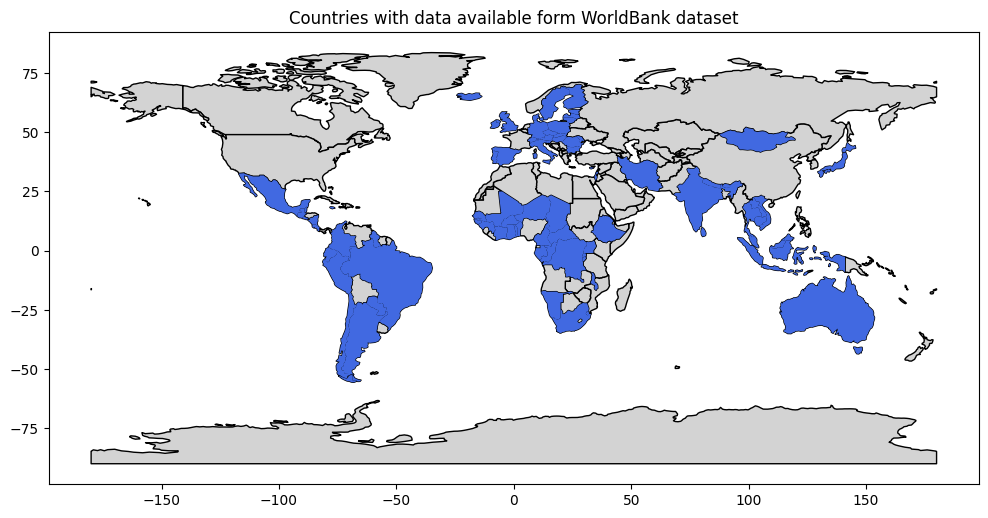

In [20]:
country_codes=df.index
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_110m_admin_0_countries.geojson")
selected_countries = world[world["ISO_A3"].isin(country_codes)]
fig, ax = plt.subplots(figsize=(12, 6))
world.plot(ax=ax, color="lightgrey", edgecolor="black")  # Default world map
selected_countries.plot(ax=ax, color=PLOT_COLOR)  # Highlighted countries
plt.title("Countries with data available form WorldBank dataset")
plt.show()


In [21]:
# function for showing correlations
def plot_corr_mesh(ax,df,cols,rect=None):
    df_feat=df[cols].corr()
    # remove the diagonal 
    df_feat=df_feat.replace(1.0,np.nan) # this is avoing to show perfectly correlated columns
    mesh=ax.pcolormesh(df_feat)
    mesh.set_clim(-1.0,1.0)
    cb=plt.colorbar(mesh,ax=ax)
    cb.ax.tick_params(labelsize=14)
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols,rotation=90)
    ax.set_yticks(range(len(cols)))
    ax.set_yticklabels(cols)

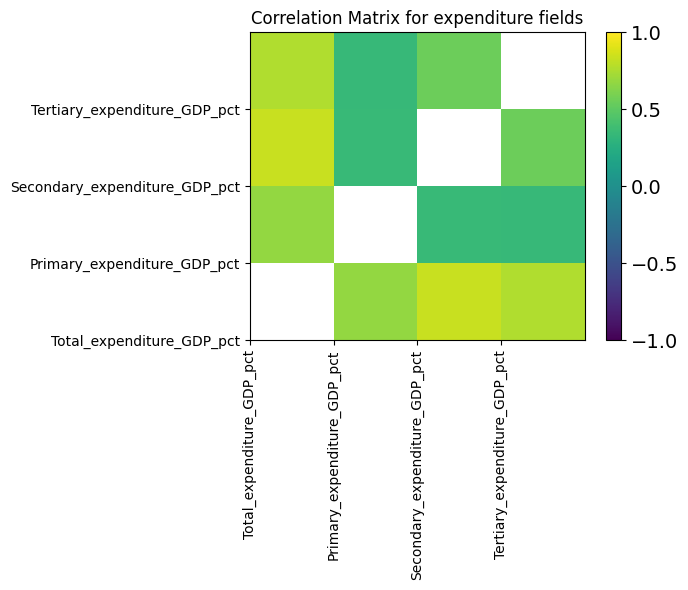

In [22]:
# show correlations between expenditures

fig,ax=plt.subplots(nrows=1,figsize=(7,6))
plot_corr_mesh(ax,df,features)
ax.set_title('Correlation Matrix for expenditure fields', fontsize=12);
fig.tight_layout()

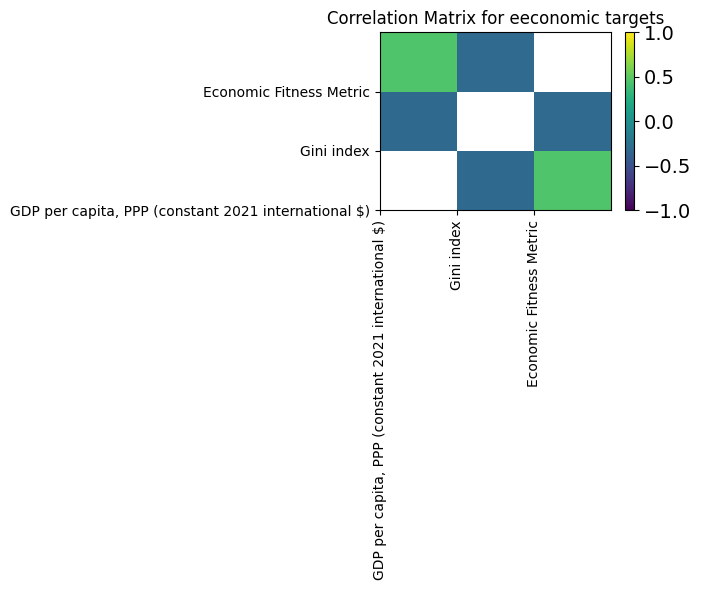

In [23]:
fig,ax=plt.subplots(nrows=1,figsize=(7,6))
plot_corr_mesh(ax,df,targets)
ax.set_title('Correlation Matrix for eeconomic targets', fontsize=12);
fig.tight_layout()

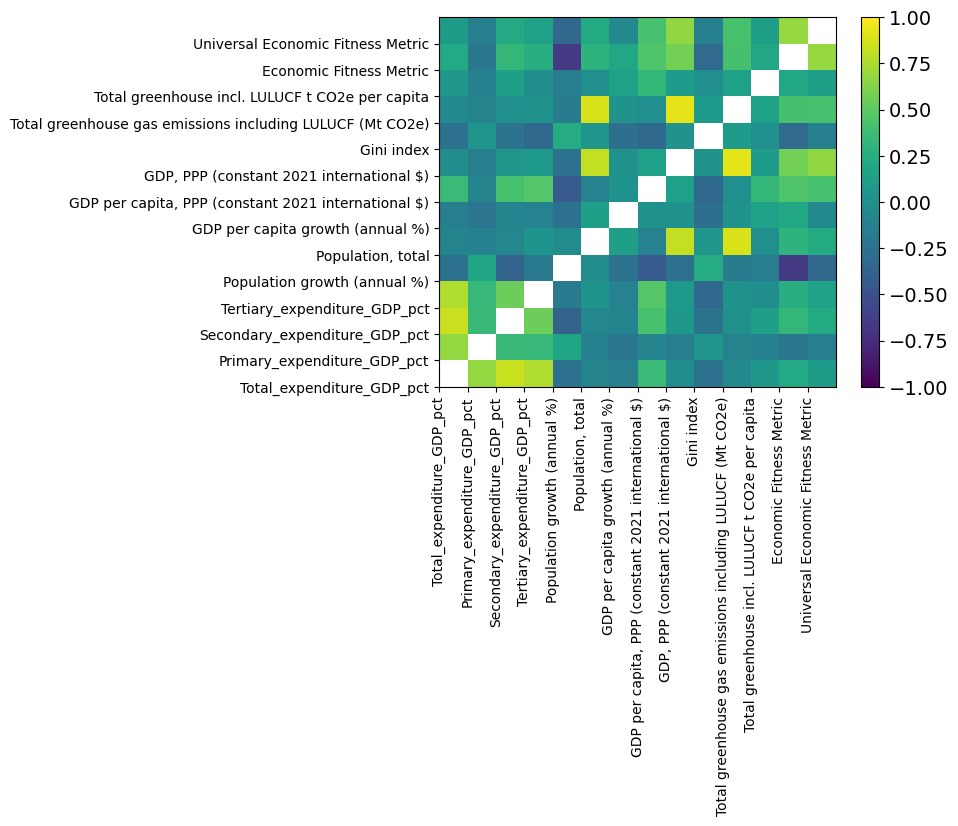

In [24]:
fig,axs=plt.subplots()
plot_corr_mesh(axs,df,df.columns)

In [25]:
def violins_plot(df,columns,ax,title,ylabel):
    # plots a violinplot
    sb.violinplot(df[columns],ax=ax,color=PLOT_COLOR)
    ax.set_title(title)
    ax.set_ylabel(ylabel)

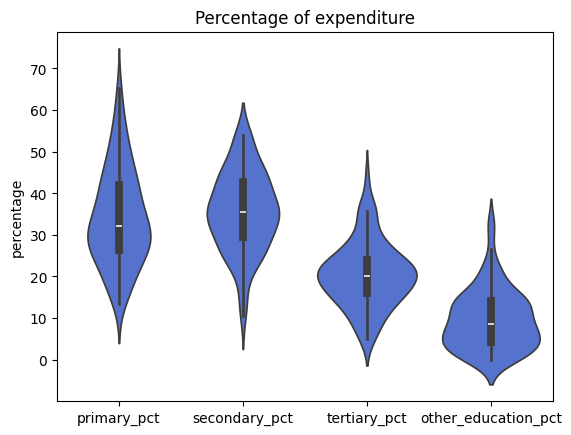

In [26]:
dfx=df.copy()
dfx["primary_pct"]=df["Primary_expenditure_GDP_pct"]/df["Total_expenditure_GDP_pct"]*100
dfx["secondary_pct"]=df["Secondary_expenditure_GDP_pct"]/df["Total_expenditure_GDP_pct"]*100
dfx["tertiary_pct"]=df["Tertiary_expenditure_GDP_pct"]/df["Total_expenditure_GDP_pct"]*100
dfx["other_education_pct"]=100-dfx[["primary_pct","secondary_pct","tertiary_pct"]].sum(axis=1)
fig,axs=plt.subplots()
violins_plot(dfx,["primary_pct","secondary_pct","tertiary_pct","other_education_pct"],axs,"Percentage of expenditure","percentage")


Total_expenditure_GDP_pct                              1.000000
Secondary_expenditure_GDP_pct                          0.834242
Tertiary_expenditure_GDP_pct                           0.763553
Primary_expenditure_GDP_pct                            0.678468
GDP per capita, PPP (constant 2021 international $)    0.357667
Gini index                                             0.243387
Economic Fitness Metric                                0.209854
Name: Total_expenditure_GDP_pct, dtype: float64


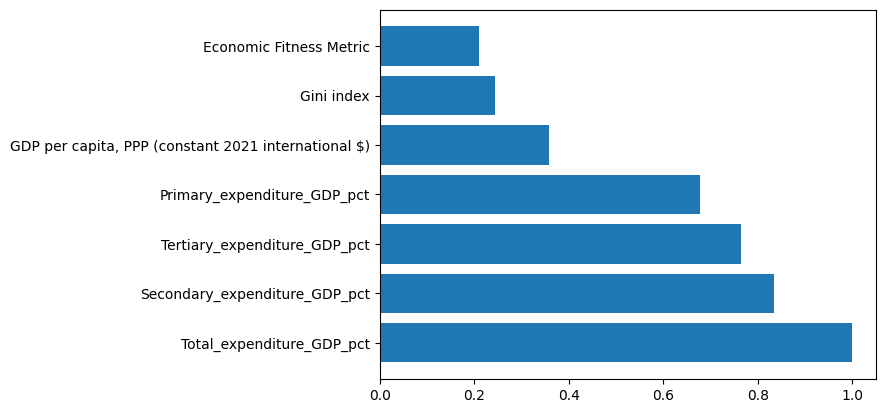

In [27]:
# showing correlations of features to total expenditure

cols=list(targets)+list(features)
total_corr=df[cols].corr()["Total_expenditure_GDP_pct"]
total_corr=abs(total_corr)
total_corr=total_corr.sort_values(ascending=False)
print (total_corr)
fig,ax=plt.subplots()
ax.barh(total_corr.index,width=total_corr.values)
ax.set_yticks(range(len(total_corr)))
ax.set_yticklabels(total_corr.index)
plt.show()

In [28]:
# as above but only the targets
selected_targets_cols=["GDP per capita, PPP (constant 2021 international $)","Gini index","Economic Fitness Metric"]
print (total_corr)

Total_expenditure_GDP_pct                              1.000000
Secondary_expenditure_GDP_pct                          0.834242
Tertiary_expenditure_GDP_pct                           0.763553
Primary_expenditure_GDP_pct                            0.678468
GDP per capita, PPP (constant 2021 international $)    0.357667
Gini index                                             0.243387
Economic Fitness Metric                                0.209854
Name: Total_expenditure_GDP_pct, dtype: float64


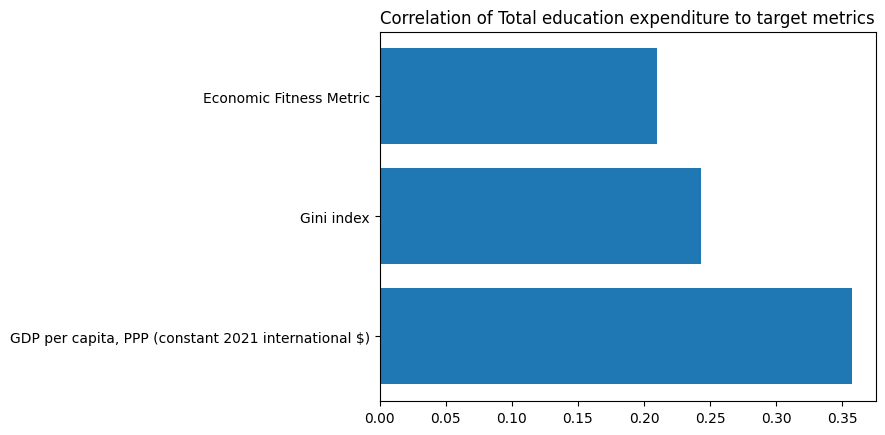

In [29]:
selected_targets=total_corr.loc[selected_targets_cols]
fig,ax=plt.subplots()
ax.barh(selected_targets.index,width=selected_targets.values)
ax.set_title("Correlation of Total education expenditure to target metrics")
plt.show()

## 4. Distributions

In [30]:
def scatter_with_regression(df,x_col,y_col,ax,xlog=False,ticks=None):
    # plots a 2d scatter plot
    x=df[x_col]
    y=df[y_col]
    ax.scatter(x,y,c=PLOT_COLOR)
    if xlog: ax.set_xscale("log")
    if ticks:
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"{x}" for x in ticks])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

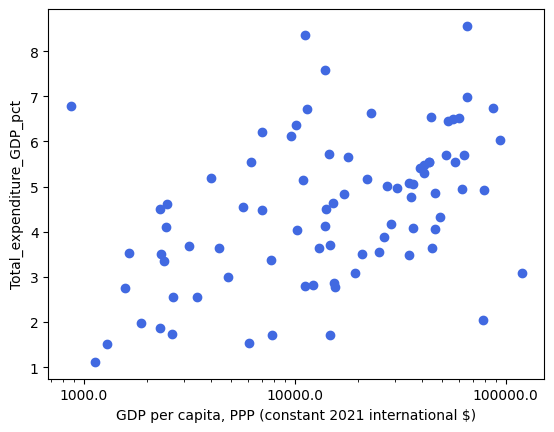

In [31]:
fig,axs=plt.subplots()
scatter_with_regression(df,"GDP per capita, PPP (constant 2021 international $)","Total_expenditure_GDP_pct",
                        axs,xlog=True,ticks=[1e3,1e4,1e5])
plt.show()

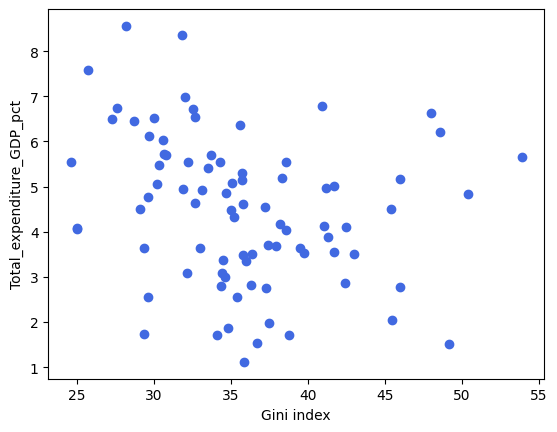

In [32]:
fig,axs=plt.subplots()
scatter_with_regression(df,"Gini index","Total_expenditure_GDP_pct",
                       axs)
plt.show()

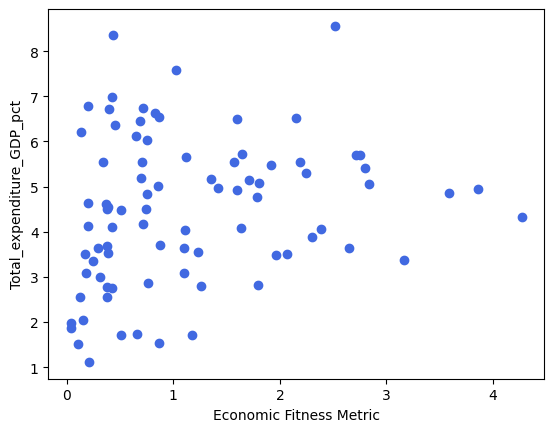

In [33]:
fig,axs=plt.subplots()
scatter_with_regression(df,"Economic Fitness Metric","Total_expenditure_GDP_pct",
                       axs)
plt.show()

## 5. Modeling

In [34]:
# standard scaling for features and targets
feature_df=df[features].copy()
target_df=df[targets].copy()
scaler_X=StandardScaler()
X=pd.DataFrame(scaler_X.fit_transform(feature_df),columns=features,index=df.index)
scaler_ys=StandardScaler()
ys=pd.DataFrame(scaler_ys.fit_transform(target_df),columns=targets,index=df.index)
# for visual sanity check: mean should be very close to zero, std very close to 1
X.describe()

,Total_expenditure_GDP_pct,Primary_expenditure_GDP_pct,Secondary_expenditure_GDP_pct,Tertiary_expenditure_GDP_pct
count,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01
mean,-3.423188e-16,2.149405e-16,1.453863e-16,4.890268e-16
std,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00
min,-2.068609e+00,-1.656977e+00,-1.846355e+00,-1.696120e+00
25%,-6.243621e-01,-7.968624e-01,-8.436220e-01,-7.594904e-01
50%,3.030367e-02,-1.140639e-01,9.536745e-02,-1.023423e-02
75%,6.552509e-01,5.394557e-01,6.888635e-01,5.965689e-01
max,2.508226e+00,2.965244e+00,2.351114e+00,2.791576e+00


In [35]:
# for visual sanity check: mean should be very close to zero, std very close to 1
ys.describe()

,"GDP per capita, PPP (constant 2021 international $)",Gini index,Economic Fitness Metric
count,8.400000e+01,8.400000e+01,8.400000e+01
mean,-2.141144e-16,-6.649360e-16,1.215959e-16
std,1.006006e+00,1.006006e+00,1.006006e+00
min,-1.004256e+00,-1.843545e+00,-1.151273e+00
25%,-7.928714e-01,-6.443300e-01,-7.940765e-01
50%,-4.304521e-01,-1.061831e-01,-3.700910e-01
75%,6.206938e-01,4.701929e-01,5.967835e-01
max,3.703238e+00,2.981545e+00,3.226671e+00


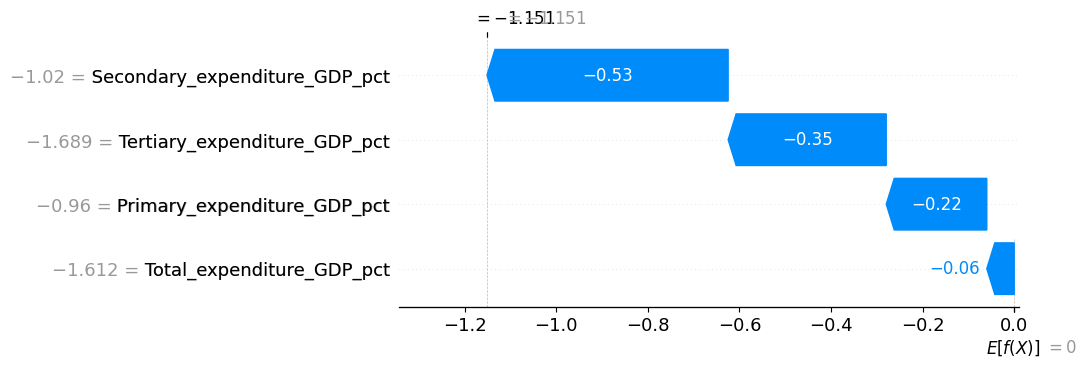

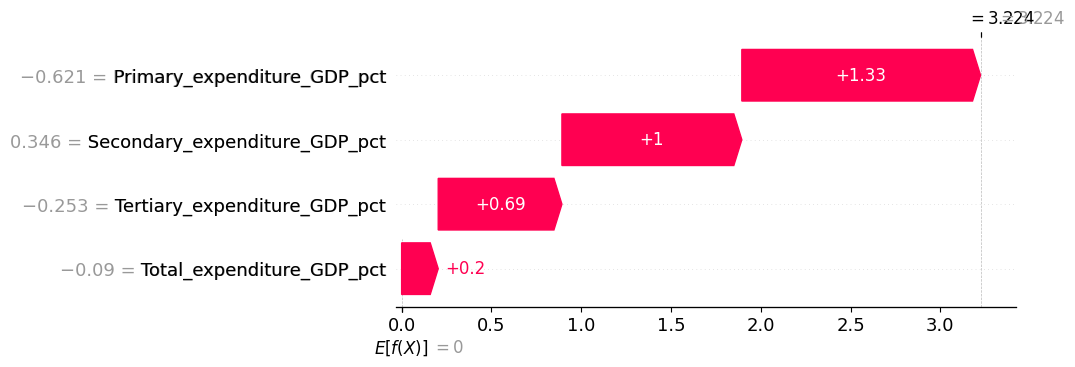

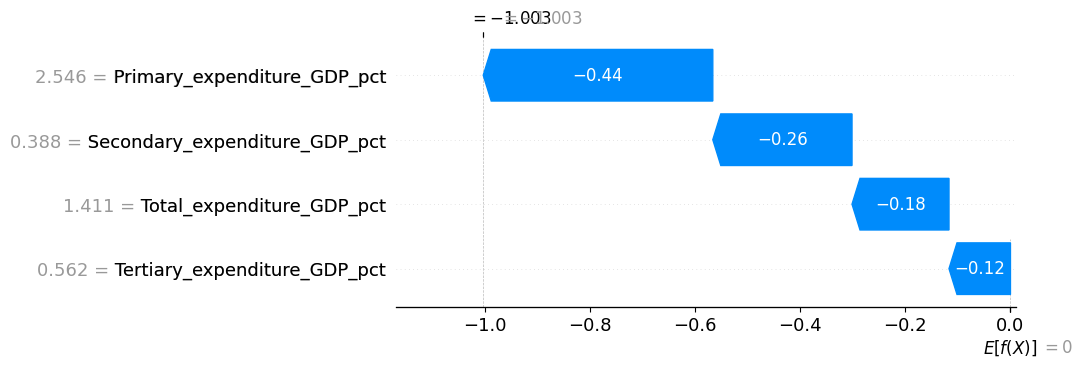

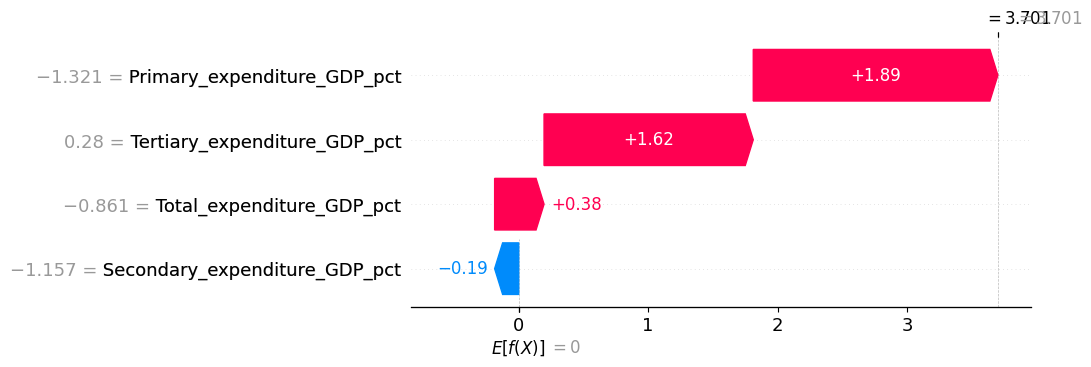

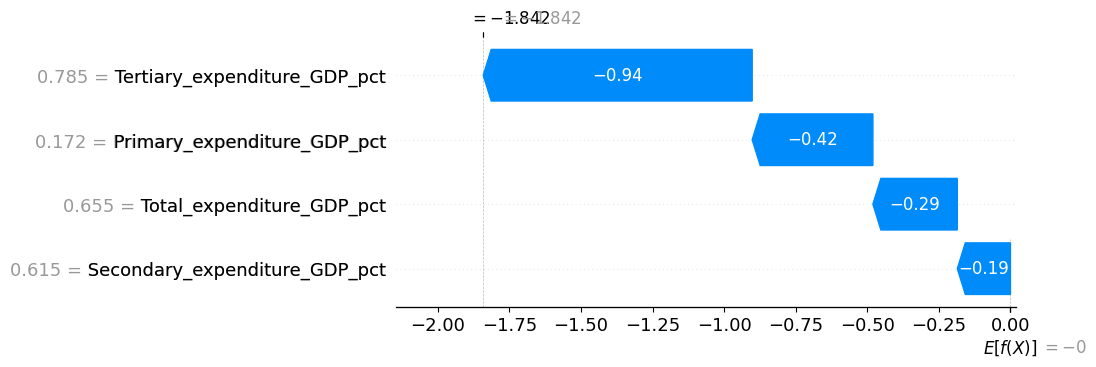

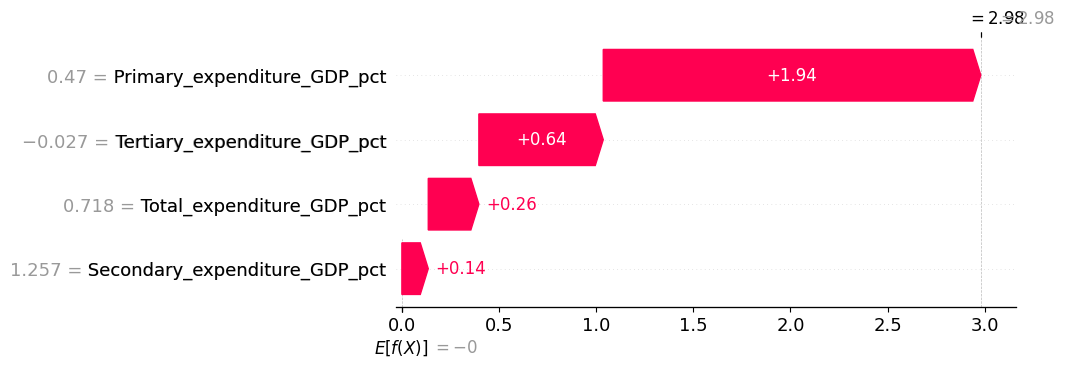

In [36]:
# here we apply and XGBRegressor to caluclate Shap values

target_shap_values=pd.DataFrame(columns=features)
# dataframe to store Shap value results
shap_dfs={}

# Looping through all relevant targets
for target in sorted(selected_targets_cols):
    # train the Regressor
    y=ys[[target]]
    xgb=xgboost.XGBRegressor().fit(X,y)
    # error calculated for debugging
    error=eval_rmse(xgb,X,y)

    # print some waterfalls. not included in report
    low_country=y.sort_values(target).head(1).index
    high_country=y.sort_values(target).tail(1).index
    shap_explainer=shap.Explainer(xgb)(X)
    low_ind=list(df.index).index(low_country)
    high_ind=list(df.index).index(high_country)
    shap.plots.waterfall(shap_explainer[low_ind])
    shap.plots.waterfall(shap_explainer[high_ind])

    # calculate Shap values via Explainer
    shap_values=shap.Explainer(xgb).shap_values(X)
    shap_df=pd.DataFrame(shap_values,columns=features).abs().sum()/shap_values.shape[0]
    # store the results in two structures for later plotting 
    shap_dfs[target]=shap_df
    target_shap_values.loc[target]=shap_df
# not including those plots. They are possibly overexaggerating the overall image for the chosen extreme cases.

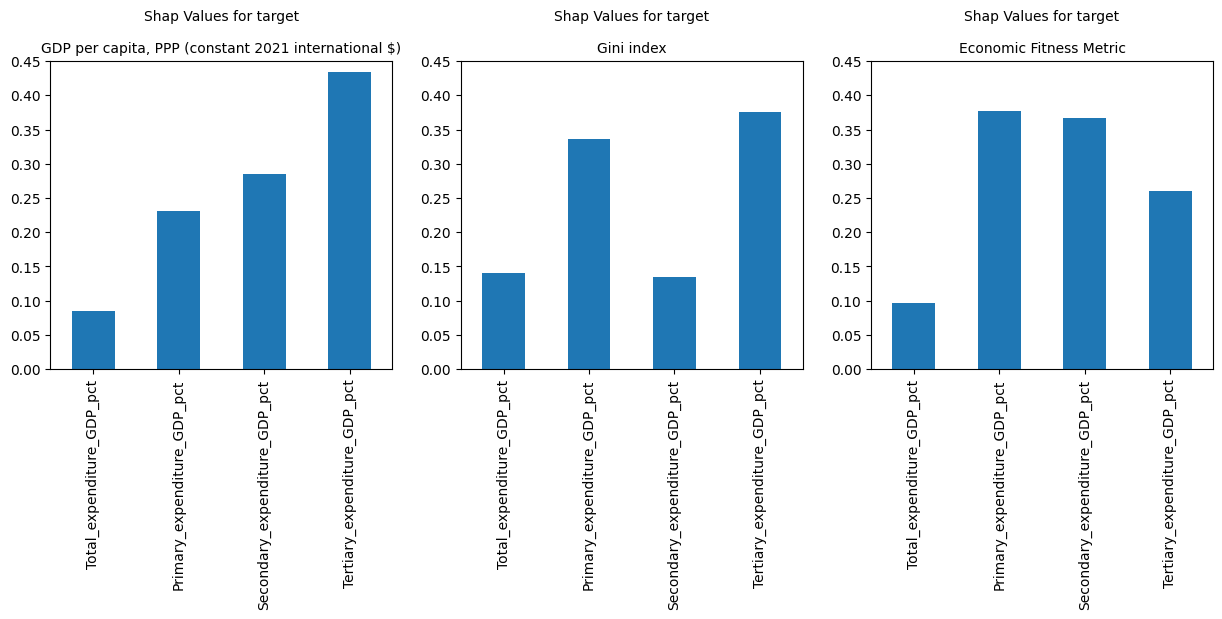

In [37]:
# bar plots from Shap values

fig,axs=plt.subplots(ncols=3,figsize=(15,4))
for n,target in enumerate(selected_targets_cols):
    shap_dfs[target].plot(ax=axs[n],kind="bar")
    axs[n].set_title(f"Shap Values for target\n\n{target}",fontsize=10)
    axs[n].set_ylim(0,0.45)
plt.show()

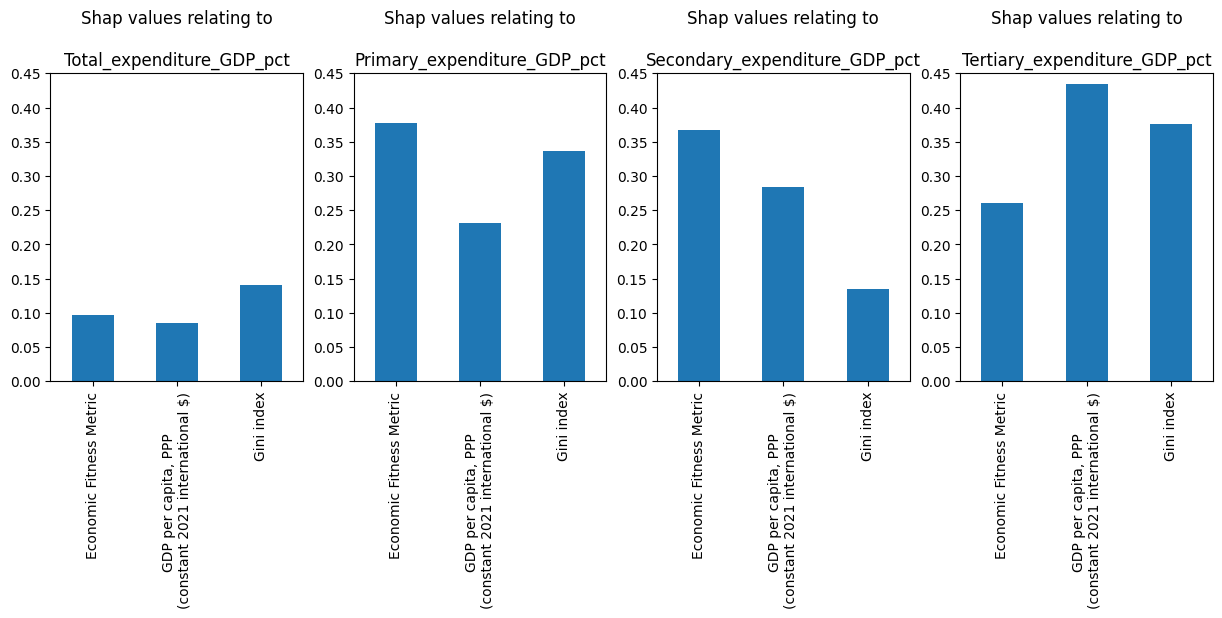

In [38]:
# prepare string for titles
GDP_title=target_shap_values.iloc[[1]].index.values[0]
GDP_title_new=GDP_title.replace("(","\n(")
target_shap_values.rename(index={GDP_title:GDP_title_new},inplace=True)

# plot second series of Shap value comparison plots
fig,axs=plt.subplots(ncols=4,figsize=(15,4))
for n,expenditure in enumerate(target_shap_values.columns):
    target_shap_values[expenditure].plot(kind="bar",ax=axs[n])
    axs[n].set_title(f"Shap values relating to\n\n{expenditure}")
    axs[n].set_ylim(0,0.45)
plt.show()